In [1]:
"""
UNCOMMENT FOR RUNNING IN COLAB ENVIRONMENT
"""
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# importing libraries

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset
from torch.nn.functional import softmax

import os
import pandas as pd
import numpy as np
import random
import scipy.spatial
import scipy.io
from copy import deepcopy
import math
from tqdm import tqdm 
import matplotlib.pyplot as plt

In [20]:
class TFDataset(Dataset):
    """
    Class to create the torch Dataset object
    """

    def __init__(self,data,name,mean,std):
        super(TFDataset,self).__init__()

        self.data=data  # dictionary
        self.name=name  # string

        self.mean= mean # numpy (4,)
        self.std = std  # numpy (4,)

    def __len__(self):
        return self.data['src'].shape[0]


    def __getitem__(self,index):
        return {'src':torch.Tensor(self.data['src'][index]),
                'trg':torch.Tensor(self.data['trg'][index]),
                'frames':self.data['frames'][index],
                'seq_start':self.data['seq_start'][index],
                'dataset':self.data['dataset'][index],
                'peds': self.data['peds'][index],
                }


def create_dataset(dataset_folder, dataset_name, val_size, gt, horizon, delim="\t", train=True, eval=False, verbose=False):
    """
    Function to import .txt file and create the torch Dataset.
    The function splits the dataset into train, val and test.

    INPUT:
    dataset_folder - (str) path to the folder containing the dataset
    dataset_name - (str) name of the dataset
    val_size - (int) number of datapoints in validation set
    gt - (int) size of the input observations to be passed to the encoder
    horizon - (int) size of the input observations to be passed to the decoder
    delim - (str) delimeter needed to read the dataset csv file
    train - (bool) boolean indicating if training dataset needs to be created. Default value = True
    eval - (bool) boolean indicating if testing dataset needs to be created. Default value = False
    verbose - (bool) boolean indicating if printing in required during code execution. Default value = False

    OUTPUT:

    object of the TFDataset class
    """

    # finding the path to the required datasets
    if train==True:
        datasets_list = os.listdir(os.path.join(dataset_folder,dataset_name, "train"))
        full_dt_folder=os.path.join(dataset_folder,dataset_name, "train")
    if train==False and eval==False:
        datasets_list = os.listdir(os.path.join(dataset_folder, dataset_name, "val"))
        full_dt_folder = os.path.join(dataset_folder, dataset_name, "val")
    # if train==False and eval==True:
    #     datasets_list = os.listdir(os.path.join(dataset_folder, dataset_name, "test"))
    #     full_dt_folder = os.path.join(dataset_folder, dataset_name, "test")


    datasets_list=datasets_list
    data={}
    data_src=[]
    data_trg=[]
    data_seq_start=[]
    data_frames=[]
    data_dt=[]
    data_peds=[]

    val_src = []
    val_trg = []
    val_seq_start = []
    val_frames = []
    val_dt = []
    val_peds=[]

    if verbose:
        print("start loading dataset")
        print("validation set size -> %i"%(val_size))


    # enumerating through all the .txt files in the required dataset folder
    for i_dt, dt in enumerate(datasets_list):
        if verbose:
            print("%03i / %03i - loading %s"%(i_dt+1,len(datasets_list),dt))
        raw_data = pd.read_csv(os.path.join(full_dt_folder, dt), delimiter=delim,
                                        names=["frame", "ped", "x", "y"],usecols=[0,1,2,3],na_values="?")

        raw_data.sort_values(by=['frame','ped'], inplace=True)

        inp,out,info=get_strided_data_clust(raw_data,gt,horizon,1)

        dt_frames=info['frames']
        dt_seq_start=info['seq_start']
        dt_dataset=np.array([i_dt]).repeat(inp.shape[0])
        dt_peds=info['peds']


        # creating validation data only if the training data is > 2.5 * validation data size
        if val_size>0 and inp.shape[0]>val_size*2.5:
            if verbose:
                print("created validation from %s" % (dt))
            k = random.sample(np.arange(inp.shape[0]).tolist(), val_size)
            val_src.append(inp[k, :, :])
            val_trg.append(out[k, :, :])
            val_seq_start.append(dt_seq_start[k, :, :])
            val_frames.append(dt_frames[k, :])
            val_dt.append(dt_dataset[k])
            val_peds.append(dt_peds[k])
            inp = np.delete(inp, k, 0)
            out = np.delete(out, k, 0)
            dt_frames = np.delete(dt_frames, k, 0)
            dt_seq_start = np.delete(dt_seq_start, k, 0)
            dt_dataset = np.delete(dt_dataset, k, 0)
            dt_peds = np.delete(dt_peds,k,0)
        elif val_size>0:
            if verbose:
                print("could not create validation from %s, size -> %i" % (dt,inp.shape[0]))

        data_src.append(inp)                # (num_datapoints in current dataset file, gt_size, 4)
        data_trg.append(out)                # (num_datapoints in current dataset file, horizon, 4)
        data_seq_start.append(dt_seq_start) # (num_datapoints in current dataset file, 1, 2)
        data_frames.append(dt_frames)       # (num_datapoints in current dataset file, 20)
        data_dt.append(dt_dataset)          # (num_datapoints in current dataset file,) data set ids
        data_peds.append(dt_peds)           # (num_datapoints in current dataset file,) pedestrian ids



    # concatenating all the dataset files in the current dataset folder
    data['src'] = np.concatenate(data_src, 0)
    data['trg'] = np.concatenate(data_trg, 0)
    data['seq_start'] = np.concatenate(data_seq_start, 0)
    data['frames'] = np.concatenate(data_frames, 0)
    data['dataset'] = np.concatenate(data_dt, 0)
    data['peds'] = np.concatenate(data_peds, 0)
    data['dataset_name'] = datasets_list

    # finding the mean and standard deviation of x and y positions of all datapoints
    mean= data['src'].mean((0,1))
    std= data['src'].std((0,1))

    # concatenate all validation dataset files
    if val_size>0:
        data_val={}
        data_val['src']=np.concatenate(val_src,0)
        data_val['trg'] = np.concatenate(val_trg, 0)
        data_val['seq_start'] = np.concatenate(val_seq_start, 0)
        data_val['frames'] = np.concatenate(val_frames, 0)
        data_val['dataset'] = np.concatenate(val_dt, 0)
        data_val['peds'] = np.concatenate(val_peds, 0)

        return TFDataset(data, "train", mean, std), TFDataset(data_val, "validation", mean, std)

    return TFDataset(data, "train", mean, std), None


def get_strided_data_clust(dt, gt_size, horizon, step):
    """
    splitting the data into clusters of a size (gt_size + horizon)

    INPUT:
    dt - (pandas df) dataframe for the dataset
    gt_size - (int) size of the input observations to be passed to the encoder
    horizon - (int) size of the input observations to be passed to the decoder 
    step - (int) integer indicating the stride/window shift

    OUTPUT:
    inp - (numpy arrays) input data to encoder. Shape = (num_datapoints, gt_size, 4)
    out - (numpy arrays) input data to decoder. Shape = (num_datapoints, horizon, 4)
    info - (dictionary) meta for dataset
    """

    inp_te = []
    dtt = dt.astype(np.float32)
    raw_data = dtt

    ped = raw_data.ped.unique()
    frame=[]
    ped_ids=[]

    # clustering the dataset by looping through all unique pedestrian ID's
    for p in ped:
        for i in range(1+(raw_data[raw_data.ped == p].shape[0] - gt_size - horizon) // step):
            frame.append(dt[dt.ped == p].iloc[i * step:i * step + gt_size + horizon, [0]].values.squeeze())
            # print("%i,%i,%i" % (i * 4, i * 4 + gt_size, i * 4 + gt_size + horizon))
            inp_te.append(raw_data[raw_data.ped == p].iloc[i * step:i * step + gt_size + horizon, 2:4].values)
            ped_ids.append(p)

    frames=np.stack(frame)
    inp_te_np = np.stack(inp_te)
    ped_ids=np.stack(ped_ids)

    # calculating the speed of the pedestrian between 2 frames
    inp_speed = np.concatenate((np.zeros((inp_te_np.shape[0],1,2)),inp_te_np[:,1:,0:2] - inp_te_np[:, :-1, 0:2]),1)

    # concatenating position and speed information
    inp_norm=np.concatenate((inp_te_np,inp_speed),2)

    inp_mean=np.zeros(4)
    inp_std=np.ones(4)

    inp = inp_norm[:,:gt_size]
    out = inp_norm[:,gt_size:]

    # seq_start - starting x,y position in every window
    info = {'mean': inp_mean, 'std': inp_std, 'seq_start': inp_te_np[:, 0:1, :].copy(),'frames':frames,'peds':ped_ids}

    return inp, out, info


def distance_metrics(target, preds):
    """
    Function to calculate MAD (mean average displacement) and FAD (final average displacement)

    INPUT:
    target - (numpy array) ground truth values for pedestrian positions
    preds - (numpy array) predicted values for pedestrian positions

    OUTPUT:
    mad - (numpy array) MAD value
    fad - (numpy array) FAD value
    errors - (numpy array) error value
    """
    
    errors = np.zeros(preds.shape[:-1])
    for i in range(errors.shape[0]):
        for j in range(errors.shape[1]):
            errors[i, j] = scipy.spatial.distance.euclidean(target[i, j], preds[i, j])

    mad = errors.mean()
    fad = errors[:,-1].mean()

    return mad, fad, errors

In [21]:
def subsequent_mask(size):
    """
    Function to compute the mask used in attention layer of decoder

    INPUT:
    size - (int) horizon size

    OUTPUT:
    mask - (torch tensor) boolean array to mask out the data in decoder
    """

    attn_shape = (1, size, size)
    mask = np.triu(np.ones(attn_shape), k=1).astype('uint8')
    mask = torch.from_numpy(mask) == 0

    return mask


def attention(Q, K, V, mask=None, dropout=None):
    """
    Function to compute the attention from given Q, K and V values 

    INPUT:
    Q - (torch tensor) query for the transformer. Shape = (B, H, N, C)
    K - (torch tensor) keys for the transformer. Shape = (B, H, N, C)
    V - (torch tensor) values for the transformer. Shape = (B, H, N, C) 
    mask - (torch tensor) mask for decoder multi head attention layer
    dropout - (float) dropout percentage

    OUTPUT:
    attn_output - (torch tensor) output of the multi head attention layer. Shape = (B, H, N, C)
    """

    # finding the embedding size
    new_emb_size = Q.shape[0]
    # calculating attention scores
    scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(new_emb_size)

    # applying mask on the attention
    if mask is not None:
        scores = scores.masked_fill_(mask == 0, -1e9)

    # applying softmax layer and calculating prob of attention
    p_attn = softmax(scores, dim=-1)

    # applying dropout
    if dropout is not None:
        p_attn = dropout(p_attn)
    
    # multiplying the prob of attentiom with Values (V)  
    attn_output = torch.matmul(p_attn, V)

    return attn_output

def cosine_scheduler(t, eta_max, T):
    """
    Function to implement cosine scheduler
    """

    T_0 = T/5

    if t <= T_0:
        lr = 1e-6 + ((t/T_0) * eta_max)
    else:
        lr = 1e-8 + (eta_max * np.cos((np.pi/2)*((t-T_0)/(T-T_0))))
    
    return lr


def learning_rate_finder(tf_model, optimizer, train_loader, iterations, device, mean, std, increment=1.1):
    """
    Function to perform the "learning rate finder" algorithm.
    """

    # initilizing array to store training loss of each minibatch
    train_loss = []
    # initializing the array to store the learning rates
    learning_rates = []

    for idx, data in enumerate(train_loader):
        # getting encoder input data
        enc_input = (data['src'][:,1:,2:4].to(device)-mean.to(device))/std.to(device)

        # getting decoder input data
        target = (data['trg'][:,:-1,2:4].to(device)-mean.to(device))/std.to(device)
        target_append = torch.zeros((target.shape[0],target.shape[1],1)).to(device)
        target = torch.cat((target,target_append),-1)
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0],1,1).to(device)
        dec_input = torch.cat((start_of_seq, target), 1)

        # getting masks for decoder
        dec_source_mask = torch.ones((enc_input.shape[0], 1,enc_input.shape[1])).to(device)
        dec_target_mask = subsequent_mask(dec_input.shape[1]).repeat(dec_input.shape[0],1,1).to(device)

        # forward pass 
        optimizer.zero_grad()
        predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)

        # calculating loss using pairwise distance of all predictions
        loss = F.pairwise_distance(predictions[:, :,0:2].contiguous().view(-1, 2),
                                    ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).\
                                    contiguous().view(-1, 2).to(device)).mean() + \
                                    torch.mean(torch.abs(predictions[:,:,2]))
        train_loss.append(loss.item())             
        # changing the learning rate 
        for param in optimizer.param_groups:
            learning_rates.append(param['lr'])
            param['lr'] *= increment
        
        # updating weights
        loss.backward()
        optimizer.step()

        if idx == iterations:
            break

    return train_loss, learning_rates

In [22]:
class MultiHeadAttention(nn.Module):
    """
    Class to create the multi head attention layer for 
    encoder and decoder
    """

    def __init__(self, num_heads, emb_size, dropout=0.1):
        """
        Class constructor

        INPUT:
        num_head - (int) number of heads in multi head attention layer
        emb_size - (int) embedding size of the data
        dropout - (float) dropout percentage. Default value = 0.1
        """
        super(MultiHeadAttention, self).__init__()

        # making sure that the embedding size is divisible by the number
        # of heads
        assert emb_size % num_heads == 0

        # caching values
        self.emb_size = emb_size
        self.num_heads = num_heads

        # creating a single MLP layer for queries, keys and values
        self.q_linear = nn.Linear(emb_size, emb_size)
        self.k_linear = nn.Linear(emb_size, emb_size)
        self.v_linear = nn.Linear(emb_size, emb_size)
        # creating MLP layer for post attention
        self.post_att = nn.Linear(emb_size, emb_size)

        # creating dropout layer
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, Q, K, V, mask=None):
        """
        forward function for MultiHeadAttention

        INPUT:
        Q - (torch tensor) query for the transformer. Shape = (B, N, C)
        K - (torch tensor) keys for the transformer. Shape = (B, N, C)
        V - (torch tensor) values for the transformer. Shape = (B, N, C)
        mask - (torch tensor) mask for decoder multi head attention layer

        OUTPUT:
        att_output - (torch tensor) output of the multi head attention layer. Shape = (B, N, C)
        """

        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)

        # passing the Q, K, and V through 1 layer MLP
        Q, K, V = self.q_linear(Q), self.k_linear(K), self.v_linear(V)  # Shape = (B, N, C)

        # splitting Q, K and V based on num_heads
        batch_size = Q.shape[0]
        new_emb_size = self.emb_size // self.num_heads

        Q = Q.reshape(batch_size, -1, self.num_heads, new_emb_size)     # Shape = (B, N, H, C//H)
        K = K.reshape(batch_size, -1, self.num_heads, new_emb_size)     # Shape = (B, N, H, C//H)
        V = V.reshape(batch_size, -1, self.num_heads, new_emb_size)     # Shape = (B, N, H, C//H)

        # permuting the dimensions of Q, K and V
        Q = Q.permute(0,2,1,3)                                          # Shape = (B, H, N, C//H)
        K = K.permute(0,2,1,3)                                          # Shape = (B, H, N, C//H)
        V = V.permute(0,2,1,3)                                          # Shape = (B, H, N, C//H)

        # calculating attention
        attn_output = attention(Q, K, V, mask, self.dropout)            # Shape = (B, H, N, C//H)

        # permuting the dimensions of attn_output and collapsing 
        # the num_heads dimension
        attn_output = attn_output.permute(0,2,1,3)                      # Shape = (B, N, H, C//H)
        attn_output = attn_output.reshape(batch_size, -1, self.emb_size)# Shape = (B, N, C)

        # applying linear layer to output of attention layer
        attn_output = self.post_att(attn_output)                        # Shape = (B, N, C)

        return attn_output

class EncoderLayer(nn.Module):
    """
    class for a single encoder layer
    """

    def __init__(self, emb_size, num_heads, ff_hidden_size, dropout=0.1):
        """
        class initializer

        INPUT:
        emb_size - (int) embedding size of the data
        num_heads - (int) number of heads in multi head attention layer
        ff_hidden_size - (int) size of the hidden layer for the feed forward network
        dropout - (float) dropout percentage. Default value = 0.1
        """
        super(EncoderLayer, self).__init__()

        # creating dropout layer
        self.dropout = nn.Dropout(dropout)

        # creating normalization layer for attention module
        self.norm_attn = nn.LayerNorm(emb_size)
        # creating normalization layer for feed forward layer
        self.norm_ff = nn.LayerNorm(emb_size)

        # creating object for multi head attention layer
        self.attn = MultiHeadAttention(num_heads, emb_size, dropout)

        # creating feed forward layer
        self.ff = nn.Sequential(nn.Linear(emb_size, ff_hidden_size),
                                nn.ReLU(), 
                                nn.Dropout(dropout),
                                nn.Linear(ff_hidden_size, emb_size))
    
    def forward(self, x):
        """
        forward pass through one encoder layer

        INPUT:
        x - (torch tensor) input data to the encoder layer. Shape = (B, N, C)

        OUTPUT:
        x - (torch tensor) output of the encoder layer. Shape = (B, N, C)
        """

        # sublayer 1: Input -> LayerNorm -> MultiHeadAttention -> Dropout -> ResidualAdd
        x = x + self.dropout(self.attn.forward(self.norm_attn(x), self.norm_attn(x), self.norm_attn(x)))    # Shape = (B, N ,C)

        # sublayer 2: Input -> LayerNorm -> FFN -> Dropout -> ResidualAdd
        x = x + self.dropout(self.ff(self.norm_ff(x)))                                                      # Shape = (B, N ,C)

        return x

class Encoder(nn.Module):
    """
    class for implementing a stack of n EncoderLayers
    """

    def __init__(self, emb_size, num_heads, ff_hidden_size, n, dropout=0.1):
        """
        class initializer

        INPUT:
        emb_size - (int) embedding size of the data
        num_heads - (int) number of heads in multi head attention layer
        ff_hidden_size - (int) size of the hidden layer for the feed forward network
        n - (int) number of encoder layers 
        dropout - (float) dropout percentage. Default value = 0.1
        """
        super(Encoder, self).__init__()
        
        # creating object for 1 encoder layer
        encoder_layer_obj = EncoderLayer(emb_size, num_heads, ff_hidden_size, dropout)
        # creating a stack of n encoder layers
        self.enc_layers = nn.ModuleList([deepcopy(encoder_layer_obj) for _ in range(n)])

        # defining LayerNorm for last layer of encoder
        self.norm = nn.LayerNorm(emb_size)

    def forward(self, x):
        """
        forward function to implement one pass through all layers of encoder

        INPUT:
        x - (torch tensor). input data. Shape = (B, N, C)

        OUTPUT:
        x - (torch tensor). output of the encoder block. Shape = (B, N, C)
        """

        for layer in self.enc_layers:
            x = layer.forward(x)               # Shape = (B, N, C)
        
        x = self.norm(x)                        # Shape = (B, N, C)

        return x

class DecoderLayer(nn.Module):
    """
    class for implementing a single decoder layer
    """

    def __init__(self, emb_size, num_heads, ff_hidden_size, dropout=0.1):
        """
        class initializer

        INPUT:
        emb_size - (int) embedding size of the data
        num_heads - (int) number of heads in multi head attention layer
        ff_hidden_size - (int) size of the hidden layer for the feed forward network
        dropout - (float) dropout percentage. Default value = 0.1
        """
        super(DecoderLayer, self).__init__()

        # creating dropout layer
        self.dropout = nn.Dropout(dropout)

        # creating normalization layer for self attention module
        self.norm_attn = nn.LayerNorm(emb_size)
        # creating normalization layer for encoder-decoder attention module
        self.norm_enc_dec = nn.LayerNorm(emb_size)
        # creating normalization layer for feed forward layer
        self.norm_ff = nn.LayerNorm(emb_size)

        # creating object for multi head self attention layer
        self.attn = MultiHeadAttention(num_heads, emb_size, dropout)
        # creating object for multi head encoder-decoder attention layer
        self.enc_dec_attn = MultiHeadAttention(num_heads, emb_size, dropout)

        # creating feed forward layer
        self.ff = nn.Sequential(nn.Linear(emb_size, ff_hidden_size),
                                nn.ReLU(), 
                                nn.Dropout(dropout),
                                nn.Linear(ff_hidden_size, emb_size))

    def forward(self, x, enc_output, source_mask, target_mask):
        """
        forward pass through one decoder layer

        INPUT:
        x - (torch tensor) input data to the decoder layer. Shape = (B, N, C)
        enc_output - (torch tensor) output of the encoder block. Shape = (B, N, C)
        source_mask - (torch tensor) mask for encoder-decoder attention layer
        target_mask - (torch tensor) mask for decoder self attention layer

        OUTPUT:
        x - (torch tensor) output of the decoder layer. Shape = (B, N ,C)
        """

        # sublayer 1: Input -> LayerNorm -> MultiHeadAttention -> Dropout -> ResidualAdd
        x = x + self.dropout(self.attn.forward(self.norm_attn(x),\
            self.norm_attn(x),self.norm_attn(x), target_mask))                          # Shape = (B, N ,C)
        
        # sublayer 2: Input -> LayerNorm -> EncoderDecoderAttention -> Dropout -> ResidualAdd
        x = x + self.dropout(self.enc_dec_attn.forward(self.norm_enc_dec(x),\
            self.norm_enc_dec(enc_output),self.norm_enc_dec(enc_output), source_mask))  # Shape = (B, N ,C)
        
        # sublayer 3: Input -> LayerNorm -> FFN -> Dropout -> ResidualAdd
        x = x + self.dropout(self.ff(self.norm_ff(x)))                                  # Shape = (B, N ,C)

        return x
        
class Decoder(nn.Module):
    """
    class for implementing stack of n decoder layers
    """

    def __init__(self, emb_size, num_heads, ff_hidden_size, n, dropout=0.1):
        """
        class initializer

        INPUT:
        emb_size - (int) embedding size of the data
        num_heads - (int) number of heads in multi head attention layer
        ff_hidden_size - (int) size of the hidden layer for the feed forward network
        n - (int) number of encoder layers 
        dropout - (float) dropout percentage. Default value = 0.1      
        """
        super(Decoder, self).__init__()

        # creating object for 1 decoder layer
        decoder_obj = DecoderLayer(emb_size, num_heads, ff_hidden_size, dropout)
        # creating stack of n decoder layers
        self.dec_layers = nn.ModuleList([deepcopy(decoder_obj) for _ in range(n)])

        # defining LayerNorm for decoder end
        self.norm = nn.LayerNorm(emb_size)

    def forward(self, x, enc_output, source_mask, target_mask):
        """
        x - (torch tensor) input data to the decoder block. Shape = (B, N, C)
        enc_output - (torch tensor) output of the encoder block. Shape = (B, N, C)
        source_mask - (torch tensor) mask for encoder-decoder attention layer
        target_mask - (torch tensor) mask for decoder self attention layer

        OUTPUT:
        x - (torch tensor) output of the decoder layer. Shape = (B, N ,C)
        """

        for layer in self.dec_layers:
            x = layer.forward(x, enc_output, source_mask, target_mask)      # Shape = (B, N, C)
        
        x = self.norm(x)                                                    # Shape = (B, N, C)

        return x

class PositionalEncoding(nn.Module):
    """
    class to implement positional encoding for encoder and decoder input data
    """

    def __init__(self, emb_size, dropout=0.1, max_len=5000):
        """
        class initializer

        INPUT:
        emb_size - (int) size of the embedding
        dropout - (float) dropout percentage. Default value = 0.1
        max_len - (int) max positional length. Default value = 5000
        """
        super(PositionalEncoding, self).__init__()

        # defining the dropout layer
        self.dropout = nn.Dropout(dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, emb_size)
        position = torch.arange(0, max_len).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * -(math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        forward pass to generate positional embeddings

        INPUT:
        x - (torch tensor) embedded data. Shape = (B, N, C) 

        OUTPUT:
        x - (torch tensor) positional embedded data. Shape = (B, N, C) 
        """

        x = x + Variable(self.pe[:, :x.size(1)], requires_grad=False)
        x = self.dropout(x)

        return x

class Embeddings(nn.Module):
    """
    class to generate the embeddings for encoder and decoder input data
    """

    def __init__(self, input_size, emb_size):
        """
        class initializer

        INPUT:
        input_size - (int) size of the input data
        emb_size - (int) size of the embedding
        """
        super(Embeddings, self).__init__()

        # caching values
        self.emb_size = emb_size

        # creating liner layer for embedding input data
        self.linear_embd = nn.Linear(input_size, emb_size)

        # creating object for positional encoding
        self.pos_encoding = PositionalEncoding(emb_size, dropout=0.1, max_len=5000)
    
    def forward(self, x):
        """
        forward pass to generate input embeddings

        INPUT:
        x - (torch tensor) input data. Shape = (B, N, input_dimension)

        OUTPUT:
        x - (torch tensor) embedded data. Shape = (B, N, C)
        """

        # creating embeddings for input data
        x = self.linear_embd(x) * math.sqrt(self.emb_size)     # Shape = (B, N, C)
        # incorporating positional embeddings
        x = self.pos_encoding.forward(x)

        return x

class OutputGenerator(nn.Module):
    """
    class to generate the output embeddings from the transformer's output
    """

    def __init__(self, emb_size, output_size):
        """
        class initializer

        INPUT:
        output_size - (int) size of the output data
        emb_size - (int) size of the embedding
        """
        super(OutputGenerator, self).__init__()

        # creating liner layer for embedding input data
        self.output_gen = nn.Linear(emb_size, output_size)
    
    def forward(self, x):
        """
        forward pass to generate the output data

        INPUT:
        x - (torch tensor) input data from transformer. Shape = (B, N, output_dimension)

        OUTPUT:
        x - (torch tensor) output data. Shape = (B, N, output_size)
        """

        x = self.output_gen(x)     # Shape = (B, N, output_size) 

        return x

class TFModel(nn.Module):
    """
    class to generate the complete transformer architecture
    """

    def __init__(self, encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
                num_heads, ff_hidden_size, n, dropout=0.1):
        """
        class initializer

        INPUT:
        encoder_ip_size - (int) dimension of the encoder input
        decoder_ip_size - (int) dimension of the decoder input
        model_op_size - (int) dimension of model's output
        emb_size - (int) data embedding size for encoder and decoder
        num_heads - (int) number of heads in multi head attention layer
        ff_hidden_size - (int) size of the hidden layer for the feed forward network
        n - (int) number of encoder layers 
        dropout - (float) dropout percentage. Default value = 0.1
        """
        super(TFModel, self).__init__()

        # creating embeddings for encoder input
        self.encoder_embedding = Embeddings(encoder_ip_size, emb_size)
        # creating embeddings for decoder input
        self.decoder_embeddings= Embeddings(decoder_ip_size, emb_size)
        
        # creating encoder block
        self.encoder_block = Encoder(emb_size, num_heads, ff_hidden_size, n, dropout)
        # creating decoder block
        self.decoder_block = Decoder(emb_size, num_heads, ff_hidden_size, n, dropout)

        # creating output generator
        self.output_gen = OutputGenerator(emb_size, model_op_size)
    
    def forward(self, enc_input, dec_input, dec_source_mask, dec_target_mask):
        """
        forward pass for the transformer model

        INPUT:
        enc_input - (torch tensot) input data to the encoder block. Shape = (B, N, encoder_ip_size)
        dec_input - (torch tensor) input data to the decoder block. Shape = (B, N, decoder_ip_size)
        enc_output - (torch tensor) output of the encoder block. Shape = (B, N, emb_size)
        source_mask - (torch tensor) mask for encoder-decoder attention layer
        target_mask - (torch tensor) mask for decoder self attention layer

        OUTPUT:
        model_output - (torch tensor) output of the model. Shape = (B, N, model_op_size)
        """

        enc_embed = self.encoder_embedding.forward(enc_input)
        encoder_output = self.encoder_block.forward(enc_embed)

        dec_embed = self.decoder_embeddings.forward(dec_input)
        decoder_output = self.decoder_block.forward(dec_embed, encoder_output, dec_source_mask, dec_target_mask)

        model_output = self.output_gen.forward(decoder_output)

        return model_output


In [23]:
# defining model save location
save_location = "/content/drive/MyDrive/ESE_546_project/models"
# defining dataset locations
dataset_folder = "/content/drive/MyDrive/ESE_546_project/datasets"
dataset_name = "raw"
# setting validation size. if val_size = 0, split percentage is 80-20
val_size = 0
# lenght of sequence given to encoder
gt = 8
# length of sequence given to decoder
horizon = 12

# creating torch datasets
train_dataset, _ = create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=True)
val_dataset, _ = create_dataset(dataset_folder, dataset_name, val_size, \
    gt, horizon, delim="\t", train=False)
# test_dataset, _ = create_dataset(dataset_folder, dataset_name, val_size, \
#     gt, horizon, delim="\t", train=False, eval=True)

# defining batch size
batch_size = 64

# creating torch dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=0)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size, shuffle=True, num_workers=0)
# test_loader = torch.utils.data.DataLoader(test_dataset, batch_size, shuffle=False, num_workers=0)

Value of eta max is: 0.0001


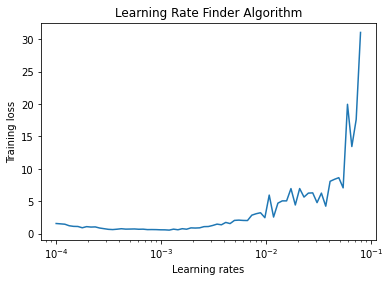

In [24]:
# learning rate finder algorithm for finding eta max

# performing training
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating model
encoder_ip_size = 2
decoder_ip_size = 3
model_op_size = 3
emb_size = 512
num_heads = 8
ff_hidden_size = 2048
n = 6
dropout=0.1

tf_model = TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
                num_heads, ff_hidden_size, n, dropout=0.1).to(device)

# number of iterations for LRF
iterations = 70

# creating optimizer
optimizer = torch.optim.SGD(tf_model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
# optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)

# calculating the mean and standard deviation of velocities of the entire dataset
mean=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).mean((0,1))
std=torch.cat((train_dataset[:]['src'][:,1:,2:4],train_dataset[:]['trg'][:,:,2:4]),1).std((0,1))
means=[]
stds=[]
for i in np.unique(train_dataset[:]['dataset']):
    ind=train_dataset[:]['dataset']==i
    means.append(torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).mean((0, 1)))
    stds.append(
        torch.cat((train_dataset[:]['src'][ind, 1:, 2:4], train_dataset[:]['trg'][ind, :, 2:4]), 1).std((0, 1)))
mean=torch.stack(means).mean(0)
std=torch.stack(stds).mean(0)

train_loss, learning_rates = learning_rate_finder(tf_model, optimizer, train_loader, iterations, device, mean, std)
eta_star = learning_rates[np.argmin(np.array(train_loss))]
eta_max = eta_star/10
print("Value of eta max is: {:.4f}".format(eta_max))

# plotting results
plt.figure()
plt.plot(learning_rates, train_loss)
plt.xlabel("Learning rates")
plt.ylabel("Training loss")
plt.xscale('log')
plt.title("Learning Rate Finder Algorithm")
plt.show()

In [28]:
# training loop

# creating model
encoder_ip_size = 2
decoder_ip_size = 3
model_op_size = 3
emb_size = 512
num_heads = 8
ff_hidden_size = 2048
n = 6
dropout=0.1

tf_model = TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
                num_heads, ff_hidden_size, n, dropout=0.1)
tf_model = tf_model.to(device)

# creating optimizer
optimizer = torch.optim.SGD(tf_model.parameters(), lr=1e-4, momentum=0.9, weight_decay=1e-3, nesterov=True)
# optimizer = torch.optim.Adam(tf_model.parameters(), lr=1e-4)

# number of epochs 
epochs = 100

# metric variables
training_loss = []
validation_loss = []
val_mad = []
val_fad = []

# finding the total number of weight updates for the network
T = epochs * len(train_loader)
# initializing variable to track the number of weight updates
weight_update = 0
# initializing variable to store the changing learning rate
learning_rate = []

for epoch in tqdm(range(epochs)):
    # TRAINING MODE
    tf_model.train()
    
    # training batch variables
    train_batch_loss = 0

    for idx, data in enumerate(train_loader):
        # changing the learning rate based on cosine scheduler
        lr = cosine_scheduler(weight_update, eta_max, T)
        for param in optimizer.param_groups:
            learning_rate.append(lr)
            param['lr'] = lr
        weight_update += 1

        # getting encoder input data
        enc_input = (data['src'][:,1:,2:4].to(device)-mean.to(device))/std.to(device)

        # getting decoder input data
        target = (data['trg'][:,:-1,2:4].to(device)-mean.to(device))/std.to(device)
        target_append = torch.zeros((target.shape[0],target.shape[1],1)).to(device)
        target = torch.cat((target,target_append),-1)
        start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(target.shape[0],1,1).to(device)
        dec_input = torch.cat((start_of_seq, target), 1)

        # getting masks for decoder
        dec_source_mask = torch.ones((enc_input.shape[0], 1,enc_input.shape[1])).to(device)
        dec_target_mask = subsequent_mask(dec_input.shape[1]).repeat(dec_input.shape[0],1,1).to(device)

        # forward pass 
        optimizer.zero_grad()
        predictions = tf_model.forward(enc_input, dec_input, dec_source_mask, dec_target_mask)

        # calculating loss using pairwise distance of all predictions
        loss = F.pairwise_distance(predictions[:, :,0:2].contiguous().view(-1, 2),
                                    ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).\
                                    contiguous().view(-1, 2).to(device)).mean() + \
                                    torch.mean(torch.abs(predictions[:,:,2]))
        train_batch_loss += loss.item()
        
        # updating weights
        loss.backward()
        optimizer.step()

    training_loss.append(train_batch_loss/len(train_loader))
    print("Epoch {}/{}....Training loss = {:.4f}".format(epoch+1, epochs, training_loss[-1]))


    # validation loop
    if (epoch+1)%5 == 0:
        with torch.no_grad():
            # EVALUATION MODE
            tf_model.eval()
            
            # validation variables
            batch_val_loss=0
            gt = []
            pr = []

            for id_b, data in enumerate(val_loader):
                # storing groung truth 
                gt.append(data['trg'][:, :, 0:2])

                # input to encoder input
                val_input = (data['src'][:,1:,2:4].to(device)-mean.to(device))/std.to(device)

                # input to decoder
                start_of_seq = torch.Tensor([0, 0, 1]).unsqueeze(0).unsqueeze(1).repeat(val_input.shape[0], 1, 1).to(device)
                dec_inp = start_of_seq
                # decoder masks
                dec_source_mask = torch.ones((val_input.shape[0], 1, val_input.shape[1])).to(device)
                dec_target_mask = subsequent_mask(dec_inp.shape[1]).repeat(dec_inp.shape[0], 1, 1).to(device)

                # prediction till horizon lenght
                for i in range(horizon):
                    # getting model prediction
                    model_output = tf_model.forward(val_input, dec_inp, dec_source_mask, dec_target_mask)
                    # appending the predicition to decoder input for next cycle
                    dec_inp = torch.cat((dec_inp, model_output[:, -1:, :]), 1)

                # calculating loss using pairwise distance of all predictions
                val_loss = F.pairwise_distance(dec_inp[:,1:,0:2].contiguous().view(-1, 2),
                                        ((data['trg'][:, :, 2:4].to(device)-mean.to(device))/std.to(device)).\
                                            contiguous().view(-1, 2).to(device)).mean() + \
                                            torch.mean(torch.abs(dec_inp[:,1:,2]))
                batch_val_loss += val_loss.item()

                # calculating the position for each time step of prediction based on velocity
                preds_tr_b = (dec_inp[:, 1:, 0:2]*std.to(device) + mean.to(device)).cpu().numpy().cumsum(1) + \
                    data['src'][:,-1:,0:2].cpu().numpy()

                pr.append(preds_tr_b)
            validation_loss.append(batch_val_loss/len(val_loader))

            # calculating mad and fad evaluation metrics
            gt = np.concatenate(gt, 0)
            pr = np.concatenate(pr, 0)
            mad, fad, _ = distance_metrics(gt, pr)
            val_mad.append(mad)
            val_fad.append(fad)

            print("Epoch {}/{}....Validation mad = {:.4f}, Validation fad = {:.4f}".format(epoch+1, epochs, mad, fad))

    if (epoch+1)%20 == 0:
        # Saving model, loss and error log files
        torch.save({
            'model_state_dict': tf_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'training_loss': training_loss,
            'validation_loss': validation_loss,
            'val_mad': val_mad,
            'val_fad':val_fad,
            'learning_rate':learning_rate
            }, os.path.join(save_location, 'raw_cosine_sgd_epoch{}.pth'.format(epoch+1)))
    

  0%|          | 0/100 [00:33<?, ?it/s]


KeyboardInterrupt: ignored

In [30]:
# loading saved model file

PATH = "/content/drive/MyDrive/ESE_546_project/models"
device = "cuda" if torch.cuda.is_available() else "cpu"
loaded_file = torch.load(os.path.join(PATH, 'raw_cosine_adam_epoch100.pth'), map_location=torch.device(device))

# creating model and loading weights
encoder_ip_size = 2
decoder_ip_size = 3
model_op_size = 3
emb_size = 512
num_heads = 8
ff_hidden_size = 2048
n = 6
dropout=0.1

model_loaded = TFModel(encoder_ip_size, decoder_ip_size, model_op_size, emb_size, \
                num_heads, ff_hidden_size, n, dropout=0.1)
model_loaded = model_loaded.to(device)
model_loaded.load_state_dict(loaded_file['model_state_dict'])

# loading training metric variables
training_loss = loaded_file['training_loss']
validation_loss = loaded_file['validation_loss']
val_mad = loaded_file['val_mad']
val_fad = loaded_file['val_fad']
learning_rate = loaded_file['learning_rate']

Text(0.5, 1.0, 'Validation FAD VS Number of Epochs')

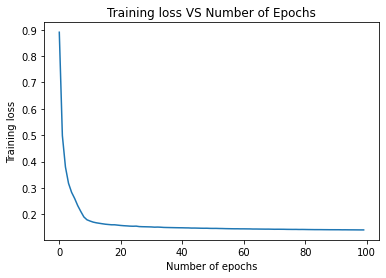

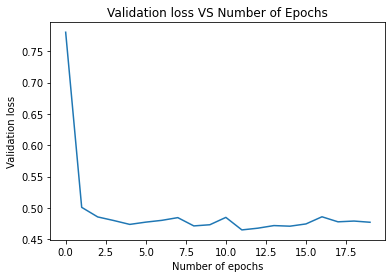

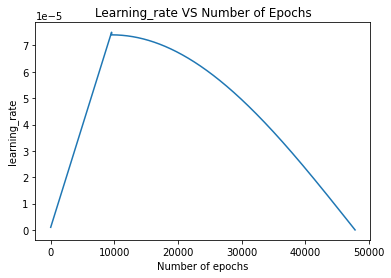

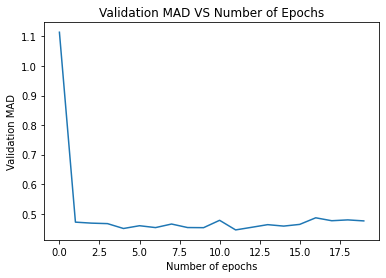

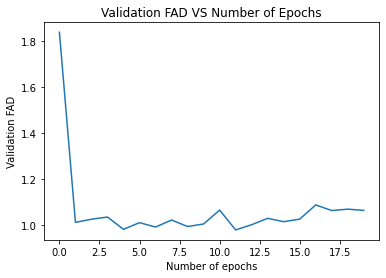

In [31]:

# plotting training loss
plt.figure()
plt.plot(training_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Training loss")
plt.title("Training loss VS Number of Epochs")

# plotting validation loss
plt.figure()
plt.plot(validation_loss)
plt.xlabel("Number of epochs")
plt.ylabel("Validation loss")
plt.title("Validation loss VS Number of Epochs")

# plotting learning rate for model
plt.figure()
plt.plot(learning_rate)
plt.xlabel("Number of epochs")
plt.ylabel("learning_rate")
plt.title("Learning_rate VS Number of Epochs")

# plotting MAD
plt.figure()
plt.plot(val_mad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation MAD")
plt.title("Validation MAD VS Number of Epochs")

# plotting FAD
plt.figure()
plt.plot(val_fad)
plt.xlabel("Number of epochs")
plt.ylabel("Validation FAD")
plt.title("Validation FAD VS Number of Epochs")